###**Mounting Google Drive**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
rand_state=42

###**Import Libraries**

In [3]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [5]:
from sklearn.metrics import confusion_matrix
def plot_conf_matrix(y_test,y_pred,uniqueclassLabel, title="CMatrix"):
  cm = confusion_matrix(y_true=y_test,y_pred=y_pred,labels=uniqueclassLabel)
  plt.figure(figsize=(5,4))
  plt.title(title)
  #ax = plt.subplot()
  sns.heatmap(cm, annot=True,cmap='Blues',
              yticklabels=uniqueclassLabel,xticklabels=uniqueclassLabel,fmt='3g')

###**Import Utility File**

In [6]:
# import sys
# path = "/content/drive/MyDrive/Colab Notebooks/Project_Dissertation"
# sys.path.insert(0,path + "/Code")
# import morningStarUtilities

In [7]:
user = 'nishitgala89'
repo = 'ProjectDissertation'
src_dir = "Code/utilities"
pyfile = "morningStarUtilities.py"

url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url}

import morningStarUtilities

--2022-01-09 01:48:27--  https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Code/utilities/morningStarUtilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6484 (6.3K) [text/plain]
Failed to rename morningStarUtilities.py to morningStarUtilities.py.1: (2) No such file or directory
Saving to: ‘morningStarUtilities.py’

morningStarUtilitie 100%[===================>]   6.33K  --.-KB/s    in 0s      

2022-01-09 01:48:27 (52.0 MB/s) - ‘morningStarUtilities.py’ saved [6484/6484]



### **Import Training Data**

In [8]:
# uploaded = files.upload()
# train_df = pd.read_csv(io.BytesIO(uploaded['morningstar_removedDuplicates_train_withoutM60.csv']))

In [9]:
train_df = pd.read_csv("https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/morningstar_removedDuplicates_train_withoutLogTransform_withoutM60.csv").set_index("SecId")

### **Import Testing Data**

In [10]:
# uploaded = files.upload()
# test_df = pd.read_csv(io.BytesIO(uploaded['morningstar_removedDuplicates_test_withoutM60.csv']))

In [11]:
test_df = pd.read_csv('https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/morningstar_removedDuplicates_test_withoutLogTransform_withoutM60.csv').set_index("SecId")

### **Defining Training, Testing varibales**

In [12]:
# imp_features = ['SustainabilityRank','GBRReturnM1','GBRReturnM3','GBRReturnM0','GBRReturnM12','GBRReturnM36','OngoingCostActual','TransactionFeeActual','FundTNAV',
# 'AverageMarketCapital','MorningstarRiskM255','AlphaM36','BetaM36','R2M36','StandardDeviationM36','SharpeM36','Size','Style']
imp_features = ['SustainabilityRank','GBRReturnM1','GBRReturnM3','GBRReturnM0','GBRReturnM36','OngoingCostActual','TransactionFeeActual','FundTNAV',
'AverageMarketCapital','MorningstarRiskM255','AlphaM36','BetaM36','StandardDeviationM36','SharpeM36','Size','Style']
X_train = train_df[imp_features]
y_train = train_df[['StarRatingM255']]

X_test = test_df[imp_features]
y_test = test_df['StarRatingM255']

In [13]:
y_train = y_train.astype('string')

In [14]:
from sklearn.preprocessing import OneHotEncoder
y_train_cat = OneHotEncoder().fit_transform(y_train[["StarRatingM255"]]).toarray()
y_train_cat.shape

(886, 5)

In [15]:
X_train.shape[1], y_train.shape, y_train_cat.shape

(16, (886, 1), (886, 5))

In [16]:
X_test.shape,y_test.shape

((296, 16), (296,))

### **Scaling the Data**

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Verify the Training and Testing distribution as per Target Variable**

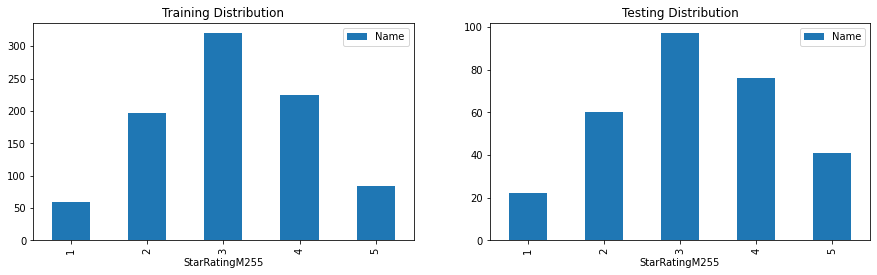

In [18]:
morningStarUtilities.displayBarSubPlots([train_df,test_df],["Training Distribution", "Testing Distribution"],
                   "StarRatingM255")

### **Creating runtime variables**

In [19]:
unique_class_label = list(train_df.StarRatingM255.unique())
unique_class_label.sort()
unique_class_label

[1, 2, 3, 4, 5]

### **Defining Neural Network Model**

In [20]:
# Number of Hidden Layers
round((X_train.shape[1] + len(unique_class_label))/2) + 1

11

### Method 1 - Using Scikit Learn - KerasClassifier


In [21]:
# def baseline_model():    
#   network = Sequential()
#   network.add(tf.keras.layers.Dense(units=11,activation ='relu', input_dim = X_train.shape[1] ))
#   network.add(tf.keras.layers.Dropout(0.2))
#   network.add(tf.keras.layers.Dense(units=11,activation ='relu'))
#   network.add(tf.keras.layers.Dropout(0.2))
#   network.add(tf.keras.layers.Dense(units=11,activation ='relu'))
#   network.add(tf.keras.layers.Dropout(0.2))
#   network.add(tf.keras.layers.Dense(5,activation='softmax'))
#   network.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#   return network

In [22]:
# from keras.wrappers.scikit_learn import KerasClassifier
# estimator = KerasClassifier(build_fn = baseline_model, epochs = 500, batch_size = 10, verbose = -1)

In [23]:
# skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# results = cross_val_score(estimator, X_train_scaled, y_train, cv = skf)

# print(results)
# print("Result: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [24]:
# y_pred = estimator.predict(X_test_scaled)

In [25]:
# plot_conf_matrix(y_test,y_pred,unique_class_label, title="Confusion Matrix for " + clf.__class__.__name__)
# print("Accuracy Score for " +  estimator.__class__.__name__ + "  " 
#         + str(accuracy_score(y_test,y_pred)) )
# print("F1 Score for " + estimator.__class__.__name__ + "  " + 
#         str(f1_score(y_test, y_pred, average='weighted')))

### Method 2 - Using Sequential Model

In [26]:
model = Sequential()
model.add(tf.keras.layers.Dense(units=13,activation ='relu', input_shape = (len(imp_features),) ))
#model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=15,activation ='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=9,activation ='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=5,activation='softmax'))
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])



In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                221       
                                                                 
 dense_1 (Dense)             (None, 15)                210       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                 144       
                                                                 
 dropout_1 (Dropout)         (None, 9)                 0         
                                                                 
 dense_3 (Dense)             (None, 5)                 50        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable pa

In [28]:
# Handling Imbalanced Classes using class_weight

class_wt = {0: 2.953333333333333,
            1: 0.899492385786802,
            2: 0.55375,
            3: 0.7875555555555556,
            4: 2.1095238095238096}

In [29]:
# history = model.fit(X_train_scaled,y_train_cat,validation_split=0.3,
#                     epochs=150, verbose=1,batch_size=25,class_weight=class_wt)
history = model.fit(X_train_scaled,y_train_cat,validation_split=0.25,
                    epochs=200, verbose=1,batch_size=20,class_weight=class_wt)

Epoch 1/200
34/34 [==============================] - 1s 9ms/step - loss: 1.8559 - accuracy: 0.1551 - val_loss: 1.7171 - val_accuracy: 0.1577
Epoch 2/200
34/34 [==============================] - 0s 3ms/step - loss: 1.7419 - accuracy: 0.1476 - val_loss: 1.6588 - val_accuracy: 0.1577
Epoch 3/200
34/34 [==============================] - 0s 3ms/step - loss: 1.6333 - accuracy: 0.1687 - val_loss: 1.6329 - val_accuracy: 0.1847
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 1.5983 - accuracy: 0.1807 - val_loss: 1.6204 - val_accuracy: 0.1982
Epoch 5/200
34/34 [==============================] - 0s 3ms/step - loss: 1.5988 - accuracy: 0.1943 - val_loss: 1.6107 - val_accuracy: 0.2027
Epoch 6/200
34/34 [==============================] - 0s 3ms/step - loss: 1.5854 - accuracy: 0.2018 - val_loss: 1.5986 - val_accuracy: 0.2207
Epoch 7/200
34/34 [==============================] - 0s 3ms/step - loss: 1.5219 - accuracy: 0.2139 - val_loss: 1.5885 - val_accuracy: 0.2162
Epoch 8/200
3

### Plot Loss and Accuracy

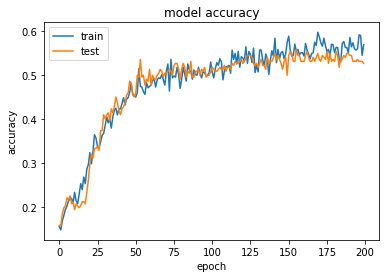

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

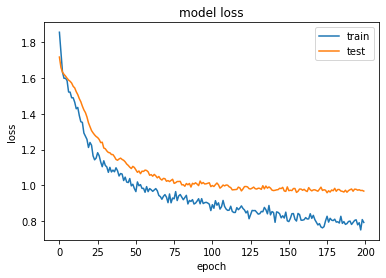

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [32]:
y_pred = model.predict(X_test_scaled)

In [33]:
y_pred

array([[2.3522529e-01, 6.2950873e-01, 1.3093488e-01, 4.3298686e-03,
        1.2972206e-06],
       [3.0352840e-37, 1.0749709e-18, 5.5971464e-07, 1.2128148e-03,
        9.9878663e-01],
       [2.9418228e-02, 4.9236906e-01, 3.8991201e-01, 8.7461531e-02,
        8.3917694e-04],
       ...,
       [7.9287995e-05, 7.3809758e-02, 4.9121344e-01, 4.0015101e-01,
        3.4746449e-02],
       [3.1465527e-02, 6.8325639e-01, 2.7504364e-01, 1.0232717e-02,
        1.7472803e-06],
       [4.3617283e-24, 6.3624751e-11, 2.6076874e-03, 1.3274717e-01,
        8.6464512e-01]], dtype=float32)

In [34]:
y_pred = np.argmax(y_pred, axis=1)

In [35]:
y_pred = y_pred + 1 # Ratings are from 1 to 5

In [36]:
y_pred

array([2, 5, 2, 3, 3, 4, 3, 4, 2, 5, 4, 3, 3, 5, 4, 2, 1, 5, 2, 5, 3, 2,
       2, 1, 5, 3, 3, 2, 5, 4, 1, 1, 4, 2, 3, 1, 2, 5, 2, 4, 4, 1, 5, 2,
       4, 5, 2, 4, 1, 2, 4, 2, 4, 2, 4, 2, 1, 5, 2, 5, 2, 5, 5, 4, 2, 4,
       3, 5, 3, 3, 2, 2, 3, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 3, 2, 2, 3, 3,
       3, 4, 2, 4, 5, 4, 3, 2, 4, 3, 1, 2, 3, 3, 5, 2, 3, 4, 4, 3, 3, 1,
       3, 1, 4, 5, 4, 5, 5, 3, 2, 3, 3, 1, 3, 2, 5, 4, 4, 3, 4, 2, 5, 3,
       4, 2, 2, 4, 2, 4, 1, 3, 5, 2, 4, 1, 2, 3, 2, 2, 4, 5, 4, 4, 4, 1,
       2, 1, 3, 4, 3, 3, 5, 4, 4, 2, 5, 5, 1, 3, 4, 4, 2, 4, 2, 3, 4, 3,
       2, 4, 3, 3, 3, 5, 3, 1, 4, 5, 3, 3, 5, 3, 5, 1, 1, 4, 2, 2, 4, 5,
       4, 4, 3, 3, 4, 5, 2, 2, 4, 4, 3, 2, 3, 4, 4, 2, 3, 3, 3, 3, 5, 2,
       4, 2, 3, 3, 2, 3, 3, 1, 2, 5, 4, 2, 3, 4, 4, 2, 5, 1, 4, 5, 4, 4,
       2, 4, 2, 4, 4, 1, 1, 2, 4, 2, 4, 4, 4, 4, 1, 2, 4, 1, 2, 2, 3, 3,
       1, 5, 3, 5, 1, 4, 2, 1, 2, 4, 4, 4, 1, 4, 2, 3, 3, 4, 4, 5, 1, 2,
       3, 2, 2, 2, 3, 1, 2, 3, 2, 5])

In [37]:
y_test.values

array([3, 5, 2, 3, 3, 3, 4, 4, 3, 5, 4, 3, 4, 4, 3, 2, 2, 5, 3, 4, 5, 3,
       2, 2, 5, 3, 4, 2, 4, 4, 2, 2, 4, 3, 2, 2, 3, 5, 2, 4, 5, 1, 5, 3,
       4, 5, 3, 3, 1, 2, 3, 1, 4, 3, 4, 2, 1, 5, 2, 5, 4, 4, 5, 4, 2, 4,
       4, 4, 3, 2, 3, 2, 4, 3, 2, 3, 5, 2, 5, 4, 2, 4, 4, 3, 3, 3, 2, 4,
       3, 4, 2, 3, 3, 3, 3, 2, 4, 2, 1, 2, 4, 4, 5, 3, 3, 4, 4, 3, 3, 3,
       3, 1, 4, 5, 5, 5, 4, 3, 2, 3, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 2,
       3, 2, 1, 3, 3, 3, 1, 4, 4, 3, 3, 1, 3, 3, 3, 2, 4, 4, 4, 3, 3, 1,
       2, 1, 3, 3, 4, 5, 4, 2, 3, 2, 5, 4, 1, 3, 4, 4, 2, 4, 2, 2, 5, 3,
       2, 5, 3, 3, 3, 4, 3, 2, 4, 5, 3, 3, 5, 3, 5, 2, 3, 3, 4, 2, 3, 4,
       4, 3, 4, 3, 5, 5, 2, 2, 4, 3, 3, 2, 3, 3, 4, 2, 5, 3, 1, 3, 5, 2,
       3, 4, 3, 3, 1, 2, 4, 2, 4, 5, 3, 2, 3, 5, 4, 1, 4, 1, 5, 5, 5, 3,
       3, 4, 2, 4, 4, 1, 2, 2, 5, 2, 4, 3, 4, 4, 2, 3, 3, 1, 3, 3, 4, 3,
       2, 5, 3, 5, 1, 4, 2, 2, 3, 4, 5, 3, 1, 4, 2, 2, 3, 3, 4, 5, 1, 2,
       3, 2, 3, 4, 4, 1, 3, 3, 3, 5])

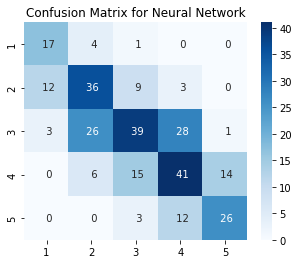

In [38]:
plot_conf_matrix(y_test.values,y_pred,unique_class_label, title="Confusion Matrix for Neural Network" )

In [39]:
print("Accuracy Score for " +  model.__class__.__name__ + "  " 
        + str(accuracy_score(y_test.values,y_pred)) )
print("F1 Score for " + model.__class__.__name__ + "  " + 
        str(f1_score(y_test.values, y_pred, average='weighted')))

Accuracy Score for Sequential  0.5371621621621622
F1 Score for Sequential  0.532646185542527


In [40]:
model_json = model.to_json()
with open('/content/model_v2.json','w') as json_file:
  json_file.write(model_json)

In [41]:
from keras.models import save_model
model_weights = save_model(model, '/content/model_weights_v2.hdf5')

#### Performing testing using Loaded model

In [42]:
with open('/content/model_v2.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 16], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_input"}}, {"class_name": "Dense", "config": {"name": "dense", "trainable": true, "batch_input_shape": [null, 16], "dtype": "float32", "units": 13, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "dtype": "float32", "units": 15, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias

In [43]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('model_weights_v2.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [44]:
y_pred_loaded = network_loaded.predict(X_test_scaled)

In [45]:
y_pred_loaded = np.argmax(y_pred_loaded, axis=1)

In [46]:
y_pred_loaded +=1

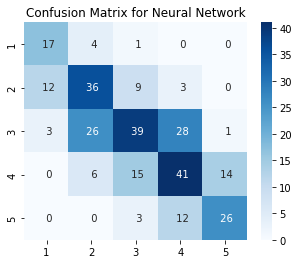

In [47]:
plot_conf_matrix(y_test.values,y_pred_loaded,unique_class_label, title="Confusion Matrix for Neural Network")

#### Prediction on Asia Developed Dataset

In [48]:
asia_df = pd.read_csv('https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/Generalization_Check_Asia_Developed.csv').set_index("SecId")
asia_df = morningStarUtilities.createSize_InvestmentTypeFeature(asia_df)


In [49]:
asia_df[asia_df.FundTNAV.isnull()]

,Name,StarRatingM255,SustainabilityRank,CategoryName,Yield_M12,GBRReturnW1,GBRReturnM1,GBRReturnM3,GBRReturnM6,GBRReturnM0,GBRReturnM12,GBRReturnM36,GBRReturnM60,MaxFrontEndLoad,OngoingCostActual,TransactionFeeActual,ManagerTenure,FundTNAV,EquityStyleBox,AverageMarketCapital,MorningstarRiskM255,AlphaM36,BetaM36,R2M36,StandardDeviationM36,SharpeM36,ReturnProfilePreservation,ReturnProfileIncome,ReturnProfileHedging,TrackRecordExtension,Size,Style
SecId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F00001071Q,BIEF Emerging Markets A GBP Acc,4,2,Global Emerging Markets Equity,0.62047,1.43,1.64,-3.35,-7.72,0.09,10.79,10.05,NaN,NaN,1.12,1.17,24.08,NaN,2,28614.24791,4,2.47,1.02,89.7,16.24,0.66,3,1,3.0,False,1,2


In [50]:
asia_df.drop(index='F00001071Q',inplace=True)


In [51]:
X_asia = asia_df[imp_features]
y_asia = asia_df['StarRatingM255']
X_asia_scaled = scaler.transform(X_asia)

In [52]:
y_asia_pred = network_loaded.predict(X_asia_scaled)
y_asia_pred = np.argmax(y_asia_pred, axis=1)
y_asia_pred += 1

In [53]:
y_asia.shape

(432,)

In [54]:
y_asia_pred.shape

(432,)

In [55]:
print("Accuracy Score for " +  model.__class__.__name__ + "  " 
        + str(accuracy_score(y_asia.values,y_asia_pred)) )
print("F1 Score for " + model.__class__.__name__ + "  " + 
        str(f1_score(y_asia.values, y_asia_pred, average='weighted')))

Accuracy Score for Sequential  0.5578703703703703
F1 Score for Sequential  0.5476033607306009


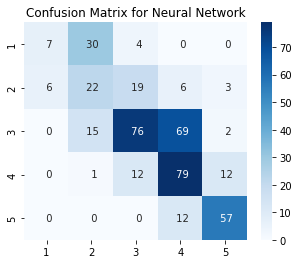

In [56]:
plot_conf_matrix(y_asia.values,y_asia_pred,unique_class_label, title="Confusion Matrix for Neural Network" )